<h3>Algorithmic Machine Learning Challenge</h3>
<h1>Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

Plankton comprises all the organisms freely drifting with ocean currents. These life forms are a critically important piece of oceanic ecosystems, accounting for more than half the primary production on earth and nearly half the total carbon fixed in the global carbon cycle. They also form the foundation of aquatic food webs, including those of large, commercially important fisheries. Loss of plankton populations could result in ecological upheaval as well as negative societal impacts, particularly in indigenous cultures and the developing world. Plankton’s global significance makes their population levels an ideal measure of the health of the world’s oceans and ecosystems.

Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. Improved approaches are needed. One such approach is through the use of underwater imagery sensors. 

In this challenge, which was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS, plankton images were acquired in the bay of Villefranche, weekly since 2013 and manually engineered features were computed on each imaged object. 

This challenge aims at developing solid approaches to plankton image classification. We will compare methods based on carefully (but manually) engineered features, with “Deep Learning” methods in which features will be learned from image data alone.

The purpose of this challenge is for you to learn about the commonly used paradigms when working with computer vision problems. This means you can choose one of the following paths:

- Work directly with the provided images, e.g. using a (convolutional) neural network
- Work with the supplied features extracted from the images (*native* or *skimage* or both of them)
- Extract your own features from the provided images using a technique of your choice


# Data Exploration and Visualization
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

<div class="">
    <h3>1. Image Visualization</h3>
</div>

In this section, we will have a first glance on the image data. As the instruction, all the images are in .jpg format and located in the *imgs.zip* file. Because of the limition in disk size, we need a function to load them into memory instead of extracting them into disk.


In [1]:
import zipfile
from io import BytesIO
from PIL import Image

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


In [2]:
base = "/mnt/datasets/plankton/flowcam/"

img_files = extract_zip_to_memory(base + "imgs.zip")

Display some images here

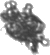

Image size:  (50, 55)
Image mode:  L


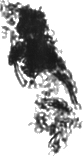

Image size:  (83, 156)
Image mode:  L


In [3]:
# Display example images
img1 = Image.open(img_files['imgs/32738710.jpg'])
img2 = Image.open(img_files['imgs/32738711.jpg'])
display(img1)
print("Image size: ", img1.size)
print("Image mode: ", img1.mode)
display(img2)
print("Image size: ", img2.size)
print("Image mode: ", img2.mode)


The very first observation shows that image size is variant. We will have a deeper exploration into these image after checking the non-labeled images if any.

<div class="">
    <h3>2. Data Exploration and Visualization</h3>
</div>

In this section, we will explore the distribution of the labels we have, non-labeled images ...

Fistly, we import necessary packages:


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


The **meta.csv** contains the image identifiers (objid) as well as the labels assigned to the images by human operators. Let's have a look on it:


In [5]:
# Load the meta.csv
df_meta = pd.read_csv(base + 'meta.csv')

# Display first 5 data
display(df_meta[:5])

# Data info
df_meta.info()

,objid,projid,id,status,latitude,longitude,objdate,objtime,depth_min,depth_max,unique_name,lineage,level1,level2
0,32756761.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
1,32759364.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
2,32758055.0,133,28299,V,43.683333,7.3,2013-09-19,00:09:00,0,75,Guinardia,/#/living/Eukaryota/Harosa/Stramenopiles/Ochro...,Guinardia,Rhizosolenids
3,32758988.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks
4,32760598.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243610 entries, 0 to 243609
Data columns (total 14 columns):
objid          243610 non-null float64
projid         243610 non-null int64
id             243610 non-null int64
status         243610 non-null object
latitude       243610 non-null float64
longitude      243610 non-null float64
objdate        243610 non-null object
objtime        243610 non-null object
depth_min      243610 non-null int64
depth_max      243610 non-null int64
unique_name    243610 non-null object
lineage        243610 non-null object
level1         240276 non-null object
level2         242607 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 26.0+ MB



Our target is the level 2 classification, let's focus on the **objid** and **level2** columns:


In [6]:
# Total number of object
no_target_obj = len(list(set(df_meta['objid'])))
print("Total n. of objects: ", no_target_obj)

# Total number of label2
no_labeled_level2 = len(list(set(df_meta['level2'])))
print("Total n. of labels: ", no_labeled_level2)

# Count number of object of each label
list_level2 = df_meta.groupby('level2', as_index=False).objid.count().sort_values(by=['objid'], \
                            ascending=False).reset_index().rename(columns={'objid':'count'})

Total n. of objects:  243610
Total n. of labels:  40



Let's check the distribution of labels:


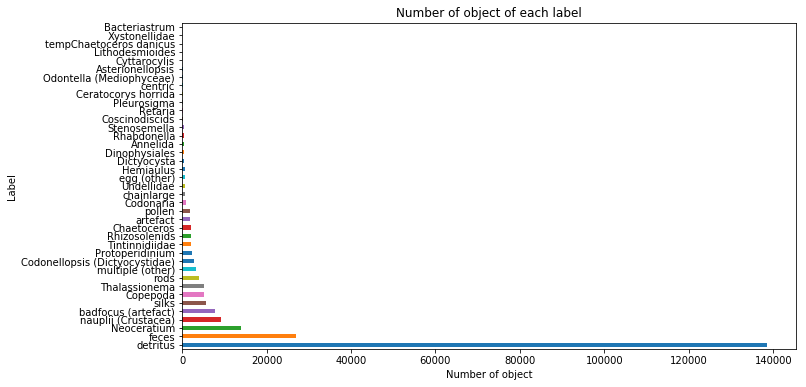

Minimum number objects of label:  12
Total labels have less than 1000 objects:  22


In [8]:
# Plot the histogram number of object of each label.
y = range(len(list_level2))

fig, ax = plt.subplots()
fig.set_size_inches(11,6)

list_level2['count'].plot(kind='barh', ax=ax)
ax.set_xlabel('Number of object')
ax.set_ylabel('Label')
ax.set_title('Number of object of each label')
plt.yticks(y, list_level2['level2'])

plt.show()
print("Minimum number objects of label: ", min(list_level2['count']))
print("Total labels have less than 1000 objects: ", len(list_level2[list_level2['count'] < 1000]))

<div>
    From the chart, the category <strong>Detrius</strong> has a significantly larger number of images compared to other labels. It has 138,439 samples while the second largest label <strong>Feces</strong> has only 26,936, just one over fifth amount objects of <strong>Detrius</strong>. Beside, there are 22 labels, more than half of the total number of labels, have less than 1000 objects. This is an <strong>imbalanced dataset</strong>. 
</div>

<div class="alert alert-warning">
    Check the number of missing data
</div>

In [79]:
#missing data
total = df_meta.isnull().sum().sort_values(ascending=False)
percent = (df_meta.isnull().sum()/df_meta.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
level1,3334,0.013686
level2,1003,0.004117
lineage,0,0.000000


<div>
There are 1003 images that have null value for level2 which takes around 0.004% of total. The number of unlabel images is insignificant then we decided to ignore them. 
</div>

In [80]:
df_meta = df_meta.dropna(subset=['level2'])

total = df_meta.isnull().sum().sort_values(ascending=False)
percent = (df_meta.isnull().sum()/df_meta.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
level1,2618,0.010791
level2,0,0.000000
lineage,0,0.000000


<div>
Now we have a full label data set, let's explore the distributio of image size and image channels.
</div>

In [24]:
# Want to know how we should format the height x width image data dimensions
# for inputting to a keras model    
from scipy import stats

heights = []
widths = []
dimensions = []
img_count = 0

for img_id in df_meta['objid']:
    img_path = 'imgs/' + str(int(img_id)) + '.jpg'
    if img_path in img_files:
        im = Image.open(img_files[img_path])
        data = np.array(im)
        heights.append(data.shape[0])
        widths.append(data.shape[1])
        dimensions.append(1 if im.mode == 'L' else 3)
        img_count += 1
    else:
        df_meta.drop(index=i)
    
avg_height = sum(heights) / len(heights)
avg_width = sum(widths) / len(widths)


Average Height: 109.33858216000985
Max Height: 739
Min Height: 2


Average Width: 86.62893559377694
Max Width: 972
Min Width: 2
Average size for Width and Height: 97.9837588768934


Total image: 243610
Dimensions: 1


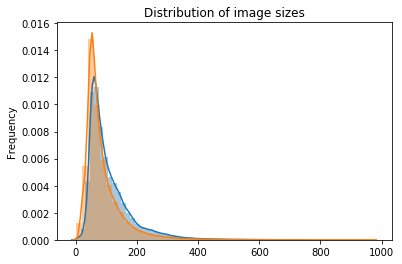

<Figure size 432x288 with 0 Axes>

In [25]:
print("Average Height: " + str(avg_height))
print("Max Height: " + str(max(heights)))
print("Min Height: " + str(min(heights)))
print('\n')
print("Average Width: " + str(avg_width))
print("Max Width: " + str(max(widths)))
print("Min Width: " + str(min(widths)))
avg_width_weight = (avg_width + avg_height) / 2
print("Average size for Width and Height: " + str(avg_width_weight))
print('\n')
print('Total image: ' + str(img_count))
print("Image channels: " + str(max(dimensions)))

sns.distplot(heights)
plt.title('Distribution of image sizes')
plt.ylabel('Frequency')
sns.distplot(widths)

plt.figure()
plt.show()

<div>
    <p>
We can see that the total number of found images is 243610, it means that <strong>all object id in meta.csv have corresponding images in imgs.zip</strong>. </p>
    <p>
    Besides, all images are in the gray mode, it means <strong>the image channel is 1</strong> for all of them.</p>
    <p>
    And as we mentioned before, it's clear that <strong>the images vary in size</strong> a lot: the smallest ones might more than 2 by 2 pixels, whereas the largest ones might up to 972 by 739 pixels. The mean value is <strong>98x98</strong> pixels</p>

    

</div>

# Data Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

In this section we concentrate into 4 main points:
- Image size: for the CNN model, all the input images must have the same size. As mentioned in previous part, our images have different sizes. We need to figure out a solution for it.
- Image augmentation: there are classes owing poor number of samples. To help the model clasify these classes, we will process some image augementation technique to increase the input for these categories.
- Label preprocess: prepare data for one hot encoding process
- Split data into testing set, training set and validation set.

We define some necessary constant variables:

In [81]:
#file path for data sets
SM_TEST_DATA_FILEPATH = "exp_test_data.npy"
SM_TRAIN_DATA_FILEPATH = "exp_train_data.npy"
SM_VAL_DATA_FILEPATH = "exp_val_data.npy"
TEST_DATA_FILEPATH = "test_data.npy"
TRAIN_DATA_FILEPATH = "train_data.npy"
VAL_DATA_FILEPATH = "val_data.npy"

#standard image size and rescale ratio
IMG_SIZE = 98
RATIO = 0.5

#total classes
NUM_CLASSES = 39

<div class="">
    <h3>1. Image resize</h3>
</div>

<div>
<p>
    Firstly we need to resize the images.
</p>
    In this challenge, we will try 2 approaches:
    <ul>
        <li><p>We simply rescale all images to a fixed size. From the chart, we see that the images peak at around from 80 to 110 in size. We caculated Average size for Width and Height and decided get 98x98 for resizing images.</p></li>
        <li><p>We try to maintain ratio between different species while rescaling the images. It’s very easy for us to see that it’s a picture of a cat or dog, however it's not the case of plankton. And it's an extremely difficult task to computer. Therefore, we try to keep important features of images as much as possible. In this case, we get 98x98 as the standard size. All images are scaled with the ratio 0.5, if it's smaller than the standard size we will fill in it with white background, otherwise we simply resize them to 98x98.</p></li>
    </ul>
</div>

Implementation for the first approach:

In [84]:
def load_image(img_id, target_size=(IMG_SIZE, IMG_SIZE)):
    img_path = 'imgs/' + str(int(img_id)) + '.jpg'
    if img_path in img_files:
        img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
        img = img.convert('L')
        img = img.resize(target_size, Image.ANTIALIAS)
        img = np.array(img)
        img = img.reshape(img.shape + (1,))
    return img 

Implementation for the second approach:

In [85]:
def adv_load_image(img_id, target_size=IMG_SIZE):
    img_path = 'imgs/' + str(int(img_id)) + '.jpg'
    if img_path in img_files:
        img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
        img = img.convert('L')
        img_width, img_height = im.size
        new_img_size = (int(img_width*RATIO), int(img_height*RATIO))
        if(min(new_img_size) > target_size):
            new_im = img.resize((target_size,target_size), Image.ANTIALIAS)
        else:
            img = img.resize(new_img_size, Image.ANTIALIAS)
            new_im = Image.new("L", (target_size, target_size), 255)
            new_im.paste(img, ((target_size - new_img_size[0])//2,
                    (target_size - new_img_size[1])//2))
        img_array = np.array(new_im)
        img_array = img_array.reshape(img_array.shape + (1,))
    return img_array 

Visualize the difference between two approaches:

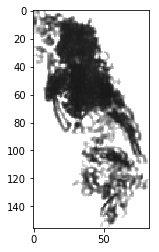

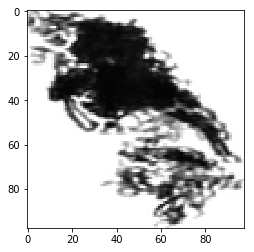

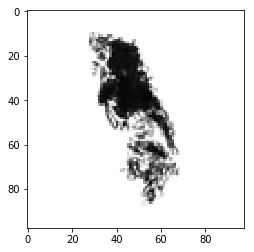

In [37]:
im = Image.open(img_files['imgs/32738711.jpg'])
im1 = load_image(32738711)
im2 = adv_load_image(32738711)

plt.imshow(im, cmap = 'gist_gray')
plt.show()
plt.imshow(im1[:,:,0], cmap = 'gist_gray')
plt.show()
plt.imshow(im2[:,:,0], cmap = 'gist_gray')
plt.show()

We can see the the approach 1 makes the shape of object modified while the approach 2 keeps the object shape and its ratio to others. It seems that approach 2 is more potential to our model. However we will do the experiments on these two approaches.

<div class="">
    <h3>2. Image augmentation</h3>
</div>

Now let's discuss about image augmentation. To increase the size of the training data set, especially when little data is available for a particular class, we will create modified versions of images before feed them into the network. The augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. We used ImageDataGenerator, only applied to the training dataset, and not to the validation or test dataset.

<div>
    <p>There are a wide range of techniques are supported, we will focus on some main types of data augmentation techniques for image data; specifically:</p>
    <li> Image rotations via the rotation_range argument</li>
    <li> Image shifts via the width_shift_range and height_shift_range arguments.</li>
    <li> Image shears via the shear_range arguments.</li>
    <li> Image zoom via the zoom_range argument.</li>
    <li> Image flips via the horizontal_flip arguments.</li>
    <br/>
    <p>Here we simulate how images are modified due to the Data augmentation. </p>
</div>

Using TensorFlow backend.


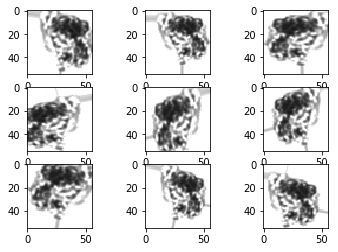

In [38]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# create image data augmentation generator
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=[0.9, 1.25],
        horizontal_flip=True)

img = load_img(img_files['imgs/32738712.jpg'])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint32')
    # plot raw pixel data
    plt.imshow(image)
    
# show the figure
plt.show()

<div class="">
    <h3>3. Label preprocess</h3>
</div>

<p>Our challenge is multiclass classification, to use CNN we need to do one hot encoding on the labels. At the first step, we convert our label from string into integer:</p>


In [86]:
level2_mapping = list_level2[['index', 'level2']].values
level2_mapping_dict = {}
level2_mapping_dict = {i[1] : i[0] for i in level2_mapping}

df_meta['level2_mapping'] = df_meta['level2'].replace(level2_mapping_dict)
print(df_meta[['objid', 'level2_mapping']][:5])
target_data = df_meta[['objid', 'level2_mapping']].values

print("Target data shape: ", target_data.shape)


        objid  level2_mapping
0  32756761.0              30
1  32759364.0              30
2  32758055.0              20
3  32758988.0              37
4  32760598.0              37
Target data shape:  (242607, 2)


<div class="">
    <h3>4. Data splitting</h3>
</div>

<p>Now our data is ready in the <strong>target_data</strong>. It is an array contains image id in the first dimension and their corresponding label in the second dimension. We split the data into three sets: a training, a validation, and a test set. </p>
    <li>A training set is used to train a network, where loss values are calculated via forward propagation and learnable parameters are updated via backpropagation.</li> 
    <li>A validation set is used to monitor the model performance during the training process, fine-tune hyperparameters, and perform model selection.</li> 
    <li>A test set is held-out to used only once at the very end of the project in order to evaluate the performance of the final model.</li> 
    <br/>
    <p>
    After splited, these arrays will be stored in files and loaded later in case we need to continually train our model.  
    Base on different purpose, we use different ratio to divide the data. </p>
<li>Small data for experiment purpose</li>
<li>Data for real training process</li>
<br/>
<p>Because the number of samples per class is variant and the smallest one has only 12 images, we prefer to keep the ratio between data sets while splitting them. The argument <strong>stratify</strong> is used for this purpose.</p>


In [53]:
from sklearn.model_selection import train_test_split

In [59]:
#use small data for experiment
small_target_data, rest_small_target_data = train_test_split(target_data, train_size=0.2, test_size=0.8, stratify=target_data[:,1])
sm_train_data, sm_test_data = train_test_split(small_target_data, train_size=0.8, test_size=0.2, stratify=small_target_data[:,1])
sm_train_data, sm_val_data = train_test_split(sm_train_data, train_size=0.8, test_size=0.2, stratify=sm_train_data[:,1])

print("Small train: ", sm_train_data.shape)
print("Small val: ", sm_val_data.shape)
print("Small test: ", sm_test_data.shape)

np.save(SM_TEST_DATA_FILEPATH, sm_test_data)
np.save(SM_TRAIN_DATA_FILEPATH, sm_train_data)
np.save(SM_VAL_DATA_FILEPATH, sm_val_data)


Small train:  (31052, 2)
Small val:  (7764, 2)
Small test:  (9705, 2)


In [61]:
#for the real train
train_data, test_data = train_test_split(target_data, train_size=0.8, test_size=0.2, stratify=target_data[:,1])
train_data, val_data = train_test_split(train_data, train_size=0.8, test_size=0.2, stratify=train_data[:,1])

print("Train: ", train_data.shape)
print("Val: ", val_data.shape)
print("Test: ", test_data.shape)

np.save(TEST_DATA_FILEPATH, test_data)
np.save(TRAIN_DATA_FILEPATH, train_data)
np.save(VAL_DATA_FILEPATH, val_data)


Train:  (155268, 2)
Val:  (38817, 2)
Test:  (48522, 2)


Excep the first run, we can load the data that are splitted already from files

In [21]:
#load data from files
test_data = np.load(TEST_DATA_FILEPATH)
train_data = np.load(TRAIN_DATA_FILEPATH)
val_data = np.load(VAL_DATA_FILEPATH)

# Model selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

<p>The difficulty of this challenge is the size of the dataset: about 243610 examples for around 40 classes. We do not have the rich knowledge about features of plankton so we came out with an approach which is very popular in computer vision aspect: Convolution Neural Networks. It is also a chance for us to learn this model.</p> 

<h3>1. Convolution Neral Network</h3>

<div>
    <strong>Why CNN?</strong>
    <li>Convolutional Neural Networks have been one of the most influential innovations in the field of computer vision. They have performed a lot better than traditional computer vision and have produced state-of-the-art results.</li>    
    <strong>Advantages:</strong>
    <li> Unlike most of the existing image classification algorithms, CNN based systems do not depend on features engineering and they can be efficiently extended to encompass new classes. CNN does not require hand-crafted feature extraction. CNN architectures do not necessarily require segmentation of tumors or organs by human experts. </li>    
    <strong>Disadvantages: </strong>
   <li>CNN is far more data hungry because of its millions of learnable parameters to estimate, and, thus, is more computationally expensive, resulting in requiring graphical processing units (GPUs) for model training.</li>    
   <li>The probably best-known disadvantage of Neural Networks is their “black box” nature, meaning that you don’t know how and why your NN came up with a certain output. For example, when you put in an image of a cat into a neural network and it predicts it to be a car, it is very hard to understand what caused it to came up with this prediction. When you have features that are human interpretable, it is much easier to understand the cause of its mistake. </li>
    <li>Usually, Neural Networks are also more computationally expensive.</li>
    <br>
    <h3>To build the model, we learn these layers to add to the model:</h3>
    <p><strong>Convolution Layer:</strong> Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data. It is a mathematical operation that takes two inputs such as image matrix and a filter or kernal We used Convolutional Layer with the input is a 32 x 32 array of pixel values. The main processing component of this layer is a filter or mask which is a matrix of weights. This mask is applied on a specified region of the feature map of the image. The purpose of this mask is to learn and identify basic pattern of which the objects in the image are made up of. As these basic shapes mostly form the edges of the object, the mask learns edge detection of the discriminating object and filters out all other features. The more filters, the greater the depth of the activation map, and the more information we have about the input volume.</p>
    <p><strong>Non Linearity (ReLU):</strong> ReLU stands for Rectified Linear Unit for a non-linear operation. The output is ƒ(x) = max(0,x).
ReLU’s purpose is to introduce non-linearity in our ConvNet. Since, the real world data would want our ConvNet to learn would be non-negative linear values. ReLU is applied after the Convolutional layer, to induce sparsity in the features and to solve the problem of vanishing gradient.</p>
    <p><strong>Pooling layers:</strong> section would reduce the number of parameters when the images are too large. Spatial pooling also called subsampling or downsampling which reduces the dimensionality of each map but retains the important information. The most popular form of pooling operation is max pooling, which extracts patches from the input feature maps, outputs the maximum value in each patch, and discards all the other values.</p>
    <p><strong>Dropout Layers:</strong> This layer “drops out” a random set of activations in that layer by setting them to zero. It forces the network to be redundant. It makes sure that the network isn’t getting too “fitted” to the training data and thus helps alleviate the overfitting problem.  </p>
    <p><strong>Fully Connected Layer:</strong> This layer basically takes an input volume (whatever the output is of the conv or ReLU or pool layer preceding it) and outputs an N dimensional vector where N is the number of classes that the program has to choose from.</p>
    
</div>

<h3>2. Model initalization</h3>

In this section, we define some necessary functions for our model. 

<strong>Data generator</strong>
As discussed, our data sets contain information about the image ids and their label. To resolve the problem with big size of data, we will create a generator to get a bunch of data to process for each time. We use the batch size of 32 as default.  

The function will return a matrix of image after normalization and their hot encoded label. If the argument augment is set to True, it will do random modifications on the images. It also makes sure that data is suffered before each epoch.


In [73]:
BATCH_SIZE = 32

In [72]:

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
)

# generator function to return images batchwise
def generator(data, augment=False, batch_size=BATCH_SIZE):
    while True:
        # Randomize the indices to make an array
        suffer_data = np.random.permutation(data)
        for batch in range(0, len(suffer_data), batch_size):
            # slice out the current batch according to batch-size
            current_batch = suffer_data[batch:(batch + batch_size)]
            
            # load image
            x_train = np.array(list(map(load_image, current_batch[:,0])))
            y_train = to_categorical(current_batch[:,1], num_classes=NUM_CLASSES)
            
            # Normalize data
            x_train = x_train.astype('float32') / 255
            
            if(augment == True):
                x_batch_train, y_batch_train = train_data_gen.flow(x_train, y_train, batch_size=batch_size).next()
                yield (x_batch_train, y_batch_train)
            else:
                yield (x_train, y_train)

Because we use custom generator, we need to calculate the steps for each epoch of training, valiation and testing phases.


In [58]:
steps_per_epoch = int(np.ceil(len(train_data) / float(BATCH_SIZE)))
validation_steps = int(np.ceil(len(val_data) / float(BATCH_SIZE)))
test_steps = int(np.ceil(len(test_data) / float(BATCH_SIZE)))

<strong>Model callbacks</strong>
After each epoch, we will save our best weights according to the validation accuracy and write the stream out into the csv log file.

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

# checkpoint
WEIGHT_FILEPATH = "exp.weights.best.hdf5"
OUTPUT_FILEPATH = "exp.output.log"
checkpoint = ModelCheckpoint(WEIGHT_FILEPATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

csvlog = CSVLogger(OUTPUT_FILEPATH, separator=',', append=True)


Import necessary packages

In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

<h3>3. Experiment for model selection</h3>

In this section, we summary what we have done to find out the final architecture for our model. Our strategy is that we begin with a simple/popular network, test and observe the result, then modify the model if needed like adding more layers, etc. 

In [66]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         110720    
__________

<div class="alert alert-warning">
<p>Compile the model</p>
</div>

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

<div class="alert alert-warning">
<p>In the case of continue training, we can load the weights which has been saved before into our model.</p>
</div>

In [21]:
#load data and weights for continue training
model.load_weights(WEIGHT_FILEPATH)

<div class="alert alert-warning">
<p>Now everything is ready, we begin train our model. For experiment purpose, we choose a batch size of 32 and number of epoch of 10.</p>
</div>

In [30]:
#final run n1
#with augaument
model.fit_generator(generator(train_data, True), steps_per_epoch = steps_per_epoch, epochs = 10, verbose = 1,
                   validation_data=generator(val_data), validation_steps = validation_steps, callbacks=[checkpoint,csvlog])


Epoch 1/10
971/971 [==============================] - 335s 345ms/step - loss: 1.2784 - acc: 0.6289 - val_loss: 1.0526 - val_acc: 0.6770

Epoch 00001: val_acc improved from -inf to 0.67697, saving model to exp.weights.best.hdf5
Epoch 2/10
971/971 [==============================] - 446s 460ms/step - loss: 0.9192 - acc: 0.7037 - val_loss: 0.8693 - val_acc: 0.7175

Epoch 00002: val_acc improved from 0.67697 to 0.71754, saving model to exp.weights.best.hdf5
Epoch 3/10
971/971 [==============================] - 516s 532ms/step - loss: 0.7686 - acc: 0.7438 - val_loss: 0.8850 - val_acc: 0.7147

Epoch 00003: val_acc did not improve from 0.71754
Epoch 4/10
971/971 [==============================] - 604s 622ms/step - loss: 0.6543 - acc: 0.7745 - val_loss: 0.7995 - val_acc: 0.7425

Epoch 00004: val_acc improved from 0.71754 to 0.74253, saving model to exp.weights.best.hdf5
Epoch 5/10
971/971 [==============================] - 563s 580ms/step - loss: 0.5438 - acc: 0.8077 - val_loss: 0.8366 - val_ac

<h4>3.1. Experiments on layers</h4>

<div>
    Because the Image Size we chose is quite small so we decided to carry out the small experiment with small filters as 3x3. We chose some layers from simple to complexity.
    <div>        
        <p>First, we run the <strong>Experment 1</strong> with these layers:</p>
    <li>Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(64, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(128, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Flatten()</li>
    <li>Dense(128, activation='relu')</li>
    <li>Dense(128, activation='relu')</li>
    <li>Dense(NUM_CLASSES, activation = 'softmax')</li>
    <p><strong>Result:</strong> Loss score: 0.6543, accuracy score: 0.7745, validation loss score: 0.7995, validation accuracy score: 0.7425. From the Epoch 4th, the validation accuracy score reached to the peak while the validation accuracy score decreased in the next Epochs. It seems data trainning is overfitting.</p>
    <p>Second, we run the <strong>Experment 2</strong>, add a Convolutional Layer with the input is a 96 x 96 array:</p>
    <li>Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(64, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(96, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(128, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Flatten()</li>
    <li>Dense(128, activation='relu')</li>
    <li>Dense(NUM_CLASSES, activation = 'softmax')</li>
    <p><strong>Result:</strong> Loss score: 0.5030, accuracy score: 0.8180, validation loss score: 0.7669, validation accuracy score: 0.7546. From the Epoch 7th, the validation accuracy score reached to the highest. It improves a bit versus Experiment 1.</p>
    <p>Third, we run the <strong>Experment 3</strong>, add a some Dropout Layers to reduce the overfitting:</p>
    <li>Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(64, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Conv2D(128, kernel_size=(3,3), activation='relu')</li>
    <li>MaxPooling2D(pool_size=(2,2))</li>
    <li>Dropout(0.2)</li>
    <li>Flatten()</li>
    <li>Dense(128, activation='relu')</li>
    <li>Dropout(0.2)</li>
    <li>Dense(128, activation='relu')</li>
    <li>Dropout(0.2)</li>
    <li>Dense(NUM_CLASSES, activation = 'softmax')</li>
    <p><strong>Result:</strong> Loss score: 0.6198, accuracy score: 0.7684, validation loss score: 0.8211, validation accuracy score: 0.7429. From the Epoch 8th, the validation accuracy score reached to the highest value. The overfitting seems improve versus Experiment 1.</p>
    </div>
</div>

<h4>3.2. Experiments on data augmentation</h4>

<h4>3.3. Experiments on image resize</h4>

# Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

In [50]:

model.evaluate_generator(generator(test_data),steps=test_steps,verbose = 1)


190/190 [==============================] - 78s 413ms/step


[0.7457601272687884, 0.7493095915721729]

In [47]:
test_generator = generator(test_data,False,batch_size=test_data.shape[0])
x_test, y_test_true = next(test_generator)
print(x_test.shape, y_test_true.shape)

(24261, 98, 98, 1) (24261, 39)


In [48]:
y_test_predict = model.predict(x_test, verbose=1)
print(y_test_predict.shape)

24261/24261 [==============================] - 87s 4ms/step
(24261, 39)


In [49]:
from sklearn.metrics import f1_score

y_true = np.argmax(y_test_true, axis=1)
y_pred = np.argmax(y_test_predict, axis=1)

score = f1_score(y_true, y_pred, average='macro') 
print("score:", score)

[30 30 32 14 30]
[30 30 30 14 30]
score: 0.3084183548366016


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

For the evaluation of the classification results, you should use the F1 measure (see Submission Instructions). Here the focus should be on level2 classification. A classification evaluation for other labels is optional.

Please note that you are responsible for creating a sensible train/validation/test split. There is no predefined held-out test data.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting Plankton (taxonomy level 2) classes.

- Your submission will be the <b>HTML version of your notebook</b> exploring the various modelling aspects described above.

- At the end of the notebook you should indicate your final evaluation score on a held-out test set. As an evaluation metric you should use the F1 score with the *average=macro* option as it is provided by the scikit-learn library. See the following link for more information:
        
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html